Reference: 

https://steam.oxxostudio.tw/category/python/example/line-webhook.html


In [ ]:
instruction = """

想要辨識植物🪴嗎?
請注意以下拍照小訣竅📸:

1. 請把植物放在照片的➡️中心點⬅️。
2. 照片中只含有1️⃣種植物。
3. 確認照片亮度💡是否適中，太亮或太暗都不行唷!
4. 拍攝近照時至少包含整片葉面🌿，不要太過靠近。

"""
print(instruction)



想要辨識植物🪴嗎?
請注意以下拍照小訣竅📸:

1. 請把植物放在照片的➡️中心點⬅️。
2. 照片中只含有1️⃣種植物。
3. 確認照片亮度💡是否適中，太亮或太暗都不行唷!
4. 拍攝近照時至少包含整片葉面🌿，不要太過靠近。




## Install Line Bot Sdk

In [ ]:
!pip install line-bot-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Install Flask Ngrok for Https Connection

In [ ]:
!pip install flask_ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount to G-Drive for pt File

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir -p /drive
!mount --bind /content/drive/My\ Drive /drive
!mkdir -p /drive/ngrok-ssh
!mkdir -p ~/.ssh

mkdir: cannot create directory ‘/drive’: File exists


## Intialize Ngrok Connection
This is to create a HTTPS enviornment for LINE bot to communicate back and forth

In [ ]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2022-08-31 15:54:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.0MB/s    in 0.8s    

2022-08-31 15:54:45 (17.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip


In [ ]:
!/ngrok authtoken 2DwlL83fE3MngXFTDT7nehIVKEK_812CC5h2i3ABDQTYsyBki
!chmod +x /ngrok

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Import Libraries

In [ ]:
from flask_ngrok import run_with_ngrok

In [ ]:
from flask import Flask, request
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import (
    MessageEvent, TextMessage, TextSendMessage,
    ImageMessage, VideoMessage, AudioMessage
)

In [ ]:
import json
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import os

from google.cloud import storage

import torch
from torch import nn
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import tensorflow as tf

## Access Token

In [ ]:
# Channel Access Token
CHANNEL_ACCESS_TOKEN = 'JYiu2547kK14k2qjEipagFX6sFp5l3seJQ6gAoKJnUDMhifZQRZy8F7s5WWNwKMU4uFjh+y5T2sPxdHHEkVkpmqesL8QuY9DCIOKpQrddisvb6Ala7CcNwA/E01/PtSyHT3sBcxe8yVRpSHIi+2L1QdB04t89/1O/w1cDnyilFU='
# Channel Secret
CHANNEL_SECRET = '78d674217e732598fe253489cf82bc5b' 

## Create NN Class

In [ ]:
class GreenFinger(object):
    def __init__(self, img):
        self.img = img
        label_dict = {
            'Aglaonema Commutatum (萬年青)': 0,
            'Asplenium Nidus (鳥巢蕨)': 1,
            'Calathea Orbifolia (竹芋)': 2,
            'Chamaedorea Elegans (袖珍椰子)': 3,
            'Dracaena Reflexa (百合竹)': 4,
            'Dracaena Trifasciata (虎尾蘭)': 5,
            'Dypsis Lutescens (散尾葵)': 6,
            'Epipremnum Aureum (黃金葛)': 7,
            'Hoya Carnosa (球蘭)': 8,
            'Maranta Leuconeura (豹紋竹芋)': 9,
            'Monstera Deliciosa (龜背芋)': 10,
            'Nephrolepis Cordifolia (腎蕨)': 11,
            'Pachira Aquatica (馬拉巴栗)': 12,
            'Peperomia Argyreia (西瓜皮椒草)': 13,
            'Peperomia Obtusifolia (圓葉椒草)': 14,
            'Philodendron Gloriosum (錦緞蔓綠絨)': 15,
            'Rhapis Excelsa (棕竹)': 16,
            'Schefflera Arboricola (鵝掌藤)': 17,
            'Tradescantia Zebrina (吊竹梅)': 18,
            'Zamioculcas (金錢樹)': 19
        }
        self.label_list = [k for k in label_dict]
        print(self.label_list)
        self.n_class = len(self.label_list)
        print(self.n_class)
        self.download_model_file()
        print(self.file_path)
        self.predict()

    def download_model_file(self):

        # Retrive pt file from GDrive, note that different approach when in GCloud
        self.file_path = '/content/drive/MyDrive/Colab Notebooks/Training_Log/CY/epoch_10_2022-08-30 10:38:20.984264.pt'

    def predict(self):

        print(f'Activate transform')
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        print(f'Transform activated')

        print(f'Send in image to transform')
        img_trans = transform(self.img).unsqueeze(0)
        print(f'Image transform completed')


        print(f'Activate model')
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, self.n_class)

        model.load_state_dict(torch.load(self.file_path, map_location="cpu")["model_state_dict"])

        model.eval()

        device = torch.device("cuda:0")

        img_trans = img_trans.to(device)
        model = model.to(device)

        print(f'Start prediction')
        pred = None
        with torch.no_grad():
            output = model(img_trans)
            prob = output.cpu().numpy()
            print(prob)
            prob = np.exp(prob)
            print(prob)
            self.prob = prob / np.sum(prob, axis=1, keepdims=True)
            print(self.prob)

        self.reply_text()

    def reply_text(self):
        idxs = np.argsort(self.prob)
        idx1 = int(idxs[0, -1])
        val1 = float(self.prob[0, idx1])

        self.txt = '{} ({:.1f}%)'.format(self.label_list[idx1], 100 * val1)

        if val1 < 0.9:
            idx2 = int(idxs[0, -2])
            val2 = float(self.prob[0, idx2])

            self.txt = self.txt + '\n{} ({:.1f}%)'.format(self.label_list[idx2], 100 * val2)
        
        print(self.txt)


## Test NN Model

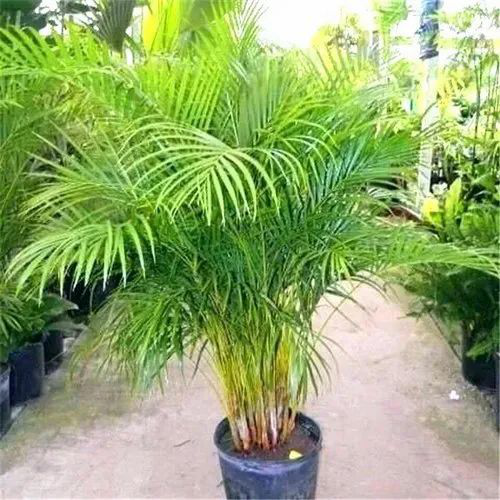

In [ ]:
resp = requests.get('https://5.imimg.com/data5/FV/KH/NO/SELLER-47552269/areca-palm-1--500x500.jpg')
img = Image.open(BytesIO(resp.content))
img

In [ ]:
model = GreenFinger(img)

['Aglaonema Commutatum (萬年青)', 'Asplenium Nidus (鳥巢蕨)', 'Calathea Orbifolia (竹芋)', 'Chamaedorea Elegans (袖珍椰子)', 'Dracaena Reflexa (百合竹)', 'Dracaena Trifasciata (虎尾蘭)', 'Dypsis Lutescens (散尾葵)', 'Epipremnum Aureum (黃金葛)', 'Hoya Carnosa (球蘭)', 'Maranta Leuconeura (豹紋竹芋)', 'Monstera Deliciosa (龜背芋)', 'Nephrolepis Cordifolia (腎蕨)', 'Pachira Aquatica (馬拉巴栗)', 'Peperomia Argyreia (西瓜皮椒草)', 'Peperomia Obtusifolia (圓葉椒草)', 'Philodendron Gloriosum (錦緞蔓綠絨)', 'Rhapis Excelsa (棕竹)', 'Schefflera Arboricola (鵝掌藤)', 'Tradescantia Zebrina (吊竹梅)', 'Zamioculcas (金錢樹)']
20
/content/drive/MyDrive/Colab Notebooks/Training_Log/CY/epoch_10_2022-08-30 10:38:20.984264.pt
Activate transform
Transform activated
Send in image to transform
Image transform completed
Activate model
Start prediction
[[-2.4553134  -1.8564863  -3.2667322  -0.04433845 -2.1089451  -1.6600553
   7.3024487  -2.7883012  -4.0809298  -3.123107   -2.5138998  -1.7653326
  -2.5764716  -2.7272036  -2.9336615  -3.3199964   1.8106017  -3.070214
  

## Initialize Chatbot

In [ ]:
app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
# def linebot(request): # use in Google Cloud Function, when use in colab, no need for request
    body = request.get_data(as_text=True)
    try:
        access_token = CHANNEL_ACCESS_TOKEN
        secret = CHANNEL_SECRET
        json_data = json.loads(body)
        print(json_data)
        line_bot_api = LineBotApi(access_token)
        handler = WebhookHandler(secret)
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        if json_data['events'][0]['message']['type'] == 'text':
            text_handler(json_data, line_bot_api)
        elif json_data['events'][0]['message']['type'] == 'image':
            image_handler(json_data, line_bot_api)
        else:
            pass
    except:
        print(request.args)
    return 'OK'

def text_handler(json_data, line_bot_api):
    print(json_data)
    msg = json_data['events'][0]['message']['text']
    print(msg)
    reply_token = json_data['events'][0]['replyToken']
    print(reply_token)
    line_bot_api.reply_message(reply_token,TextSendMessage(msg))

def image_handler(json_data, line_bot_api):
    id = json_data['events'][0]['message']['id']
    print(id)
    img = line_bot_api.get_message_content(id).content
    print(img)
    reply_token = json_data['events'][0]['replyToken']
    print(reply_token)
    img = Image.open(BytesIO(img))
    print(img)
    h, w, c = np.array(img).shape
    print(f'{h}, {w}, {c}')

    try:
        model = GreenFinger(img)
        pred = model.pred_label
    except:
        print(request.args)

    line_bot_api.reply_message(reply_token,TextSendMessage(f'{pred}'))

if __name__ == "__main__":
  run_with_ngrok(app)           # 串連 ngrok 服務
  app.run()

Output hidden; open in https://colab.research.google.com to view.